<a href="https://colab.research.google.com/github/vijay13267/Music_Genre_classification/blob/main/Colab%20Notebooks/MusicGenreClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Dependencies

In [ ]:
!pip install ffmpeg

  Created wheel for ffmpeg: filename=ffmpeg-1.4-cp37-none-any.whl size=6084 sha256=588f834466238ff10bdd3420ce05e2b785ffb281d784800810c7771d682ac006
  Stored in directory: /root/.cache/pip/wheels/b6/68/c3/a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg


In [ ]:
!pip install pydub

In [ ]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp37-none-any.whl size=5888 sha256=c23b27fe0e779fbd0d53cb7c9f03e098c80bd559bbf0c2d648e3ecdf7f438821
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


# Importing Required Modules

In [ ]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np

from tempfile import TemporaryFile

import os
import pickle
import random
import operator

import math

# Extracting the Features of Music File and writing it into a File in Binary Format 

In [ ]:
# directory that holds the wav files
directory = "/content/drive/MyDrive/Music_Genre_classification/GTZAN_dataset/genres_original/"
# binary file where we will collect all the features extracted using mfcc (Mel Frequency Cepstral Coefficients)
f = open("/content/drive/MyDrive/Music_Genre_classification/Colab Notebooks/my.dat", 'wb')

i = 0

for folder in os.listdir(directory):
    i += 1
    if i == 11:
        break
    for file in os.listdir(directory+folder):        
        try:
            (rate, sig) = wav.read(directory+folder+"/"+file)
            mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)
            covariance = np.cov(np.matrix.transpose(mfcc_feat))
            mean_matrix = mfcc_feat.mean(0)
            feature = (mean_matrix, covariance, i)
            pickle.dump(feature, f)
        except Exception as e:
            print('Got an exception: ', e, ' in folder: ', folder, ' filename: ', file)        

f.close()

# Splitting The Dataset into Training and Testing set

In [15]:
dataset = []

def loadDataset(filename, split, trSet, teSet):
    with open(filename, 'rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trSet.append(dataset[x])
        else:
            teSet.append(dataset[x])
trainingSet = []
testSet = []
loadDataset('/content/drive/MyDrive/Music_Genre_classification/Colab Notebooks/my.dat', 0.75, trainingSet, testSet)

In [16]:
def distance(instance1 , instance2 , k ):
    distance =0 
    mm1 = instance1[0] 
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1)) 
    distance+=(np.dot(np.dot((mm2-mm1).transpose() , np.linalg.inv(cm2)) , mm2-mm1 )) 
    distance+= np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance-= k
    return distance

In [17]:
def getNeighbors(trainingSet, instance, k):
    distances = []
    for x in range(len(trainingSet)):
        dist = distance(trainingSet[x], instance, k) + distance(instance, trainingSet[x], k)
        distances.append((trainingSet[x][2], dist))

    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    
    return neighbors

In [18]:
# identify the class of the instance
def nearestClass(neighbors):
    classVote = {}

    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1

    sorter = sorted(classVote.items(), key = operator.itemgetter(1), reverse=True)

    return sorter[0][0]

In [19]:
def getAccuracy(testSet, prediction):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == predictions[x]:
            correct += 1
    
    return (1.0 * correct) / len(testSet)

# Getting Accuracy of the Model

In [20]:
# making predictions using KNN
leng = len(testSet)
predictions = []
for x in range(leng):
    predictions.append(nearestClass(getNeighbors(trainingSet, testSet[x], 7)))

accuracy1 = getAccuracy(testSet, predictions)
print(accuracy1*100)

73.27935222672065


In [21]:
from collections import defaultdict
results = defaultdict(int)

directory = "/content/drive/MyDrive/Music_Genre_classification/GTZAN_dataset/genres_original"
i = 1
for folder in os.listdir(directory):
    results[i] = folder
    i += 1
#print(results)

# Taking Input File (.wav / if .mp3 converting to .wav)

In [27]:
#if input file is of .mp3 format
from os import path
from pydub import AudioSegment

# files                 
test_dir="/content/drive/MyDrive/Music_Genre_classification/songs_to_test_output"                                                        
src = test_dir+"/heartbraker.mp3"
dst = test_dir+"/HeartBreaker.wav"

# convert wav to mp3                                                            
sound = AudioSegment.from_mp3(src)
sound.export(dst, format="wav")


t1 = 0.5 * 60000 #Works in milliseconds
t2 = 1* 60000
newAudio = AudioSegment.from_wav(dst)
newAudio = newAudio[t1:t2]
newAudio.export(dst, format="wav")

test_file=dst


In [ ]:
#if input file is of .wavformat
test_dir="/content/drive/MyDrive/Music_Genre_classification/songs_to_test_output"

test_file=test_dir+"test4.wav"

# Displaying the Waveplot and Spectogram of the Music file 

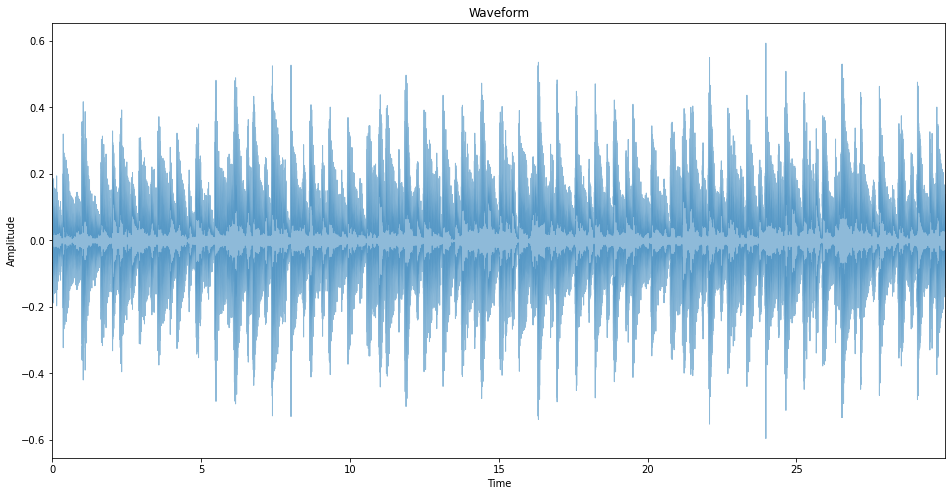

In [23]:

import matplotlib.pyplot as plt
import librosa,librosa.display
import numpy as np
sig,rate=librosa.load(test_file)
#print(rate,sig)
fig_size=(16,8)
plt.figure(figsize=fig_size)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Waveform")
librosa.display.waveplot(sig,rate,alpha=0.5)

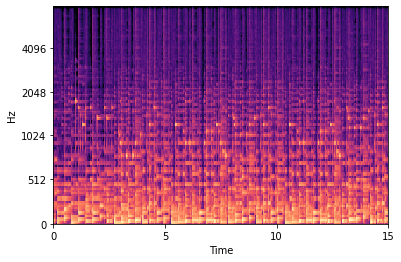

In [24]:
import librosa,librosa.display
import numpy as np
y, sr = librosa.load(test_file)
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');

# Extracting the features of Input File and Predicting the Genre

In [25]:
import scipy.io.wavfile as wav

(rate, sig) = wav.read(test_file)
mfcc_feat = mfcc(sig, rate,nfft=1000, winlen=0.020, appendEnergy=False)
covariance = np.cov(np.matrix.transpose(mfcc_feat))
mean_matrix = mfcc_feat.mean(0)
#print("mfcc_feat",mfcc_feat)
#print("covariance : ",covariance)
#print("mean_matrix:",mean_matrix)

feature = (mean_matrix, covariance, 0)
#print("feature:",feature)

In [26]:
pred = nearestClass(getNeighbors(dataset, feature, 5))
print(results[pred])

hiphop
